## Tools

In [1]:
import sys
import random
from math import ceil

class  KLL:
    def __init__(self, k, c = 1, lazy=True, alternate=True, seed=None):
        if k<=0: raise ValueError("k must be a positive integer.")
        if c <= 0.5 or c > 1.0: raise ValueError("c must larger than 0.5 and at most 1.0.")
        self.k = k
        self.c = c
        self.lazy = lazy
        self.alternate = alternate
        self.compactors = []
        self.H = 0
        self.size = 0
        self.maxSize = 0
        self.rng = random.Random(seed)
        self.grow()

    def grow(self):
        self.compactors.append(Compactor(self.rng, self.alternate))
        self.H = len(self.compactors)
        self.maxSize = sum(self.capacity(height) for height in range(self.H))

    def capacity(self, hight):
        depth = self.H - hight - 1
        return int(ceil(self.c**depth*self.k)) + 1

    def update(self, item):
        self.compactors[0].append(item)
        self.size += 1
        if self.size >= self.maxSize:
            self.compress()
            assert(self.size < self.maxSize)

    def compress(self):
        for h in range(len(self.compactors)):
            if len(self.compactors[h]) >= self.capacity(h):
                if h+1 >= self.H: self.grow()
                self.compactors[h+1].extend(self.compactors[h].compact())
                self.size = sum(len(c) for c in self.compactors)
                if(self.lazy):
                    break

    def merge(self, other):
        # Grow until self has at least as many compactors as other
        while self.H < other.H: self.grow()
        # Append the items in same height compactors
        for h in range(other.H): self.compactors[h].extend(other.compactors[h])
        self.size = sum(len(c) for c in self.compactors)
        # Keep compressing until the size constraint is met
        while self.size >= self.maxSize:
            self.compress()
        assert(self.size < self.maxSize)

    def rank(self, value):
        r = 0
        for (h, c) in enumerate(self.compactors):
             for item in c:
                if item <= value:
                    r += 2**h
        return r

    def cdf(self, x):
        itemsAndWeights = []
        totWeight = 0
        for (h, items) in enumerate(self.compactors):
            totWeight += 2**h * len(items)
            itemsAndWeights.extend( (item, 2**h) for item in items if item < x )
        itemsAndWeights.sort()
        cumWeight = 0
        for (item, weight) in itemsAndWeights:
            cumWeight += weight
        return float(cumWeight) / (float(totWeight) + 0.0001)

class Compactor(list):
    def __init__(self, rng, alternate=True):
        self.rng = rng
        self.numCompaction = 0
        self.offset = 0
        self.alternate = alternate

    def compact(self):
        if (self.numCompaction%2==1 and self.alternate):
            self.offset = 1 - self.offset
        else:
            self.offset = int(self.rng.random() < 0.5)

        self.sort()

        lastItem = None
        if (len(self)%2==1):
            lastItem = self.pop(-1)

        for i in range(self.offset,len(self),2):
            yield self[i]

        self.clear()
        if lastItem is not None:
            self.append(lastItem)

        self.numCompaction += 1

In [2]:
from itertools import combinations

def equal_size_histogram(X):
    
    values = np.sort(X)
    n = len(values)
    eps = 3
    best_hist, best_K = sketch.Histogram(), 20
        
    for k in range(2, 50):
        new_hist = sketch.Histogram(max_bins=k)
        for x in values :
            new_hist.update(x)
        
        for i in range(k):
            bin_observations_count = new_hist[i].count
            bin_width.append(bin_observations_count)
            
            combinaisons = list(combinations(bin_width, 2))
            array_combinaisons = np.array(combinaisons)
            vect_abs = np.zeros((len(array_combinaisons),1))

            for i in range(0,len(array_combinaisons)):
                vect_abs[i] = np.abs(array_combinaisons[i][1]- array_combinaisons[i][0])
            vect_boolean = [True if x <= eps else False for x in vect]
            
            if vect_boolean.count(False) <= 27 :
                best_hist = new_hist
                best_K = K
    
    return best_hist, best_K

In [3]:
#X = [random.uniform(0, 1) for _ in range(100)]
#equal_size_histogram(X)

## Methods

### Paper method

In [49]:
def paper_method(hist, N):

    # Initialize the chi2
    chi2 = 0

    # Calculate the degrees of freedom
    K = 20
    df = K - 1

    # Iterate over the bins of the sample
    for i in range(1,K+1):
        
        Ei = N/K

        # Calculate the probability corresponding to the ith bin
        p_l = (i-1)/K
        #q_l = river.stats.Quantile(p_l)
        i_l = hist.cdf(p_l) # Calculate the value x such that the CDF of the hypothesized distribution is equal to p
        
        p_u = (i)/K
        #q_u = river.stats.Quantile(p_u)
        i_u = hist.cdf(p_u) # Calculate the value x such that the CDF of the hypothesized distribution is equal to p

        Oi = N*(i_u-i_l)
        lambda_i = np.abs(Oi - Ei)

        if lambda_i > 2*np.sqrt(N):
            chi2 += chi2 + ((lambda_i)**2) / Ei
            break

        chi2 += chi2 + ((lambda_i)**2) / Ei
  
    return chi2

### Histogram method

In [50]:
def histogram_method(hist):
    
    histogram_width = hist[-1].right - hist[0].left

    chi2 = 0
    
    for i in range(len(hist) - 1):
        bin_width = hist[i + 1].left - hist[i].left
        bin_relative_width = bin_width / histogram_width
        expected_count = bin_relative_width * hist.n
        bin_count = hist[i].count
        chi2 += ((bin_count - expected_count) ** 2) / expected_count
    
    return chi2

### Scipy method

In [51]:
import scipy.stats

def scipy_method(hist):
    return scipy.stats.chisquare(hist)

### KLL

In [64]:
def kll_method(kll):

    # Initialize the chi2
    chi2 = 0

    # Calculate the degrees of freedom
    K = 20
    N = 1000
    df = K - 1

    # Iterate over the bins of the sample
    for i in range(1,K+1):
        
        Ei = N/K

        # Calculate the probability corresponding to the ith bin
        p_l = (i-1)/K
        #q_l = river.stats.Quantile(p_l)
        i_l = kll.cdf(p_l) # Calculate the value x such that the CDF of the hypothesized distribution is equal to p
        
        p_u = (i)/K
        #q_u = river.stats.Quantile(p_u)
        i_u = kll.cdf(p_u) # Calculate the value x such that the CDF of the hypothesized distribution is equal to p

        Oi = N*(i_u-i_l)
        lambda_i = np.abs(Oi - Ei)

        if lambda_i > 2*np.sqrt(N):
            chi2 += chi2 + ((lambda_i)**2) / Ei
            break

        chi2 += chi2 + ((lambda_i)**2) / Ei
  
    return chi2


### Quantile 1

In [65]:
def define_quantile(K, quantiles):
    
    for b in range(0,K):
        if ((b-1)/K < 1 and (b-1)/K > 0) and ((b)/K < 1 and (b)/K > 0):
            q_l = stats.Quantile((b-1)/K)
            q_u = stats.Quantile(b/K)

            quantiles.append([q_l, q_u])
    
    return quantiles

In [66]:
def update_quantile(x, quantiles):
    
    for b in range(0,K):
        if ((b-1)/N < 1 and (b-1)/N > 0) and ((b)/N < 1 and (b)/N > 0) and (b>0) and (b<len(quantiles)):
            quantiles[b][0].update(x)
            quantiles[b][1].update(x)
            

In [67]:
def quantile1(hist, N, K, quantiles):

    # Initialize the chi2
    chi2 = 0

    # Calculate the degrees of freedom
    #expected frequency
    Oi = N/K
    
    # Iterate over the bins of the sample
    for b in range(2, K+2):

        if ((b-1)/N < 1 and (b-1)/N > 0) and ((b)/N < 1 and (b)/N > 0) and (b>0) and (b<len(quantiles)) :

            p_l = quantiles[b][0].get()
            p_u = quantiles[b][1].get()

            i_l = hist.cdf(p_l)
            i_u = hist.cdf(p_u)

            Ei = (i_u-i_l)*N
            
            lambda_i = np.abs(Oi - Ei)

            chi2 += chi2 + ((lambda_i)**2) / Ei
  
    return chi2

In [68]:
### Quantile 2 
def quantile2(quantile_list, N):

    x_min_quant = quantile_list[0].get()
    x_max_quant = quantile_list[-1].get()

    # Initialize the chi2
    chi2 = 0
    Ei = 0
    
    for i in range(0, len(quantile_list)-1):
        borne_inf = quantile_list[i].get()
        borne_sup = quantile_list[i+1].get()
        
        Oi = 1/(len(quantile_list)+2) #By definition, between 2 quantiles. We add 2 for Q0 and Q1
        
        if x_max_quant-x_min_quant !=0:
            
            ####
            # We are expecting to have an uniform distrib, that why we can make the following assumptions
            expected_quantile_size = (x_max_quant-x_min_quant)*(1/(len(quantile_list)-2))
            Q0 = x_min_quant - expected_quantile_size
            Q1 = x_max_quant + expected_quantile_size
            
            Ei = np.abs((borne_sup-borne_inf)/(Q1-Q0))
            ####

            if Ei !=0:
                chi2 += ((((Oi - Ei)*N) ** 2) / (Ei*N))

    return chi2

In [69]:
from river import stats
def define_quantile2(quantile_list):

    #num_quantiles = 21 Paper says to use 20 bins for 1e7 data points
    num_quantiles = 10

    for i in range(1, num_quantiles):
        quantile_list.append(stats.Quantile(i/num_quantiles))
    return quantile_list

In [70]:
def update_quantile2(quantile_list):
    for quantile in quantile_list:
        quantile.update(x)

## Benchmark

In [71]:
import random
import numpy as np
import collections
from river import stats
from river import sketch
from scipy.stats import uniform
cms = sketch.Counter(epsilon=0.005, seed=0)

N = 1000
X = [random.uniform(0, 1) for _ in range(N)]
K = 10
c = 1

#X = np.random.normal(0, 1, N)
#c = 3

river_histogram = sketch.Histogram(max_bins=K)
kll = KLL(K)

quantiles1 = []
quantiles1 = define_quantile(K, quantiles1)

quantile_list = []
quantile_list = define_quantile2(quantile_list)

chi2_results = {
    'histogram_paper': [],
    'histogram': [],
    'scipy': [],
    'critical': [],
    'kll_paper' : [],
    'quantile1': [],
    'quantile2': [],
    'quantile3': [],
    'quantile4': []}

for i, x in enumerate(X, start=1):
 
    river_histogram.update(x)
    #kll.update(x)
    numpy_histogram, _ = np.histogram(X[:i], bins=K)
    
    update_quantile(x, quantiles1)
    
    update_quantile2(quantile_list)
    
    chi2_results['histogram_paper'].append(paper_method(river_histogram, N))
    chi2_results['histogram'].append(histogram_method(river_histogram))
    chi2_results['scipy'].append(scipy_method(numpy_histogram)[0])
    chi2_results['critical'].append(scipy.stats.chi2.ppf(1 - 0.005, K-c))
    chi2_results['kll_paper'].append(kll_method(kll))
    chi2_results['quantile1'].append(quantile1(river_histogram, i, K, quantiles1))
    chi2_results['quantile2'].append(quantile2(quantile_list, i))

/var/folders/1_/9z90xr695979cpbpnzc2tdfh0000gn/T/ipykernel_2339/3584112462.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  chi2 += chi2 + ((lambda_i)**2) / Ei
/var/folders/1_/9z90xr695979cpbpnzc2tdfh0000gn/T/ipykernel_2339/1554278123.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  chi2 += chi2 + ((lambda_i)**2) / Ei


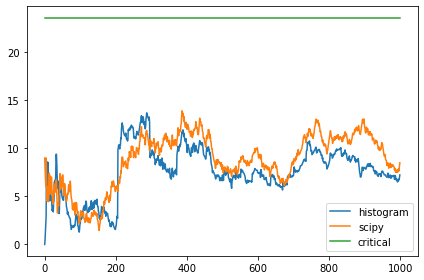

In [72]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

#ax.plot(chi2_results['histogram_paper'], label='histogram_paper')
ax.plot(chi2_results['histogram'], label='histogram')
ax.plot(chi2_results['scipy'], label='scipy')
ax.plot(chi2_results['critical'], label='critical')

ax.legend()

fig.tight_layout()

The hypothesis fails to reject if the chi2 value is below the critical value (below the green curve)

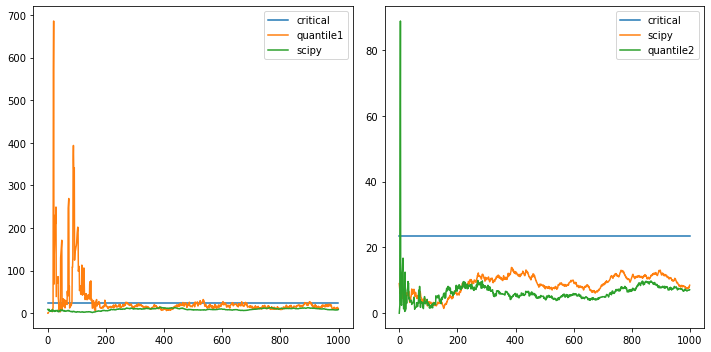

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(chi2_results['critical'], label='critical')
ax[0].plot(chi2_results['quantile1'], label='quantile1')
ax[0].plot(chi2_results['scipy'], label='scipy')
ax[0].legend()

ax[1].plot(chi2_results['critical'], label='critical')
ax[1].plot(chi2_results['scipy'], label='scipy')
ax[1].plot(chi2_results['quantile2'], label='quantile2')
ax[1].legend()

#ax.set_xlim(50, 1000)
#ax.set_ylim(0, 100)

fig.tight_layout()

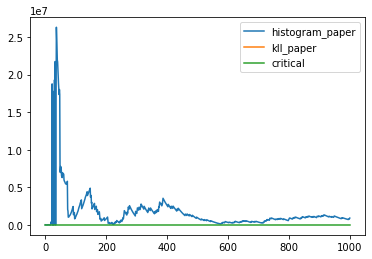

In [75]:
# Bad results 
fig, ax = plt.subplots()
ax.plot(chi2_results['histogram_paper'], label='histogram_paper')
ax.plot(chi2_results['kll_paper'], label='kll_paper')
ax.plot(chi2_results['critical'], label='critical')
ax.legend()